**Spine Segmentation network training and inference testing notebook**

Luke Hammond, Cellular Imaging

5 June, 2023

Spine segmentation pipeline for Polleux Lab
- Initial notebook for training resnet34 unet for spine segmentation using pretrained segmentation model
- bottom cells can use trained model for inference on new data
- includes functions for padding and patching and currently set to work with data up to 1024x1024 dimensions. Larger images can easily be accomodated
- Future changes will be made in training and inference specific notebooks with functions stored seperately to facilitate transition to automated pipeline
- improvements: seperate test set early on and don't augment these images

Currently trained model available here: https://www.dropbox.com/s/8snm87e0pgu1thv/2023_05_spine_2D%20256x256_resnet34_V3_2.h5?dl=0

(Store models in spine-analysis\Models\)

In [158]:
import numpy as np
import pandas as pd

import cv2
import os
import random

#io
import tifffile as tiff
from tifffile import imread

import glob
from skimage import io

#CNN
import tensorflow as tf
import segmentation_models as sm
from patchify import patchify, unpatchify
import keras 
from keras.utils import normalize
from keras.metrics import MeanIoU

#vis
from matplotlib import pyplot as plt

#image analysis
from scipy.ndimage import rotate
from skimage import exposure
from scipy.ndimage import rotate, gaussian_filter
from skimage.measure import label
from skimage import color, data, filters, measure, morphology, segmentation, util, exposure, restoration

In [11]:
#Make sure the GPU is available. 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [159]:
#Importer Helper Functions

def pad_image(image, divisible_by=(64, 256, 256), pad_value=0):
    # Calculate padding for each axis
    padding = [(div - (dim % div)) % div for dim, div in zip(image.shape, divisible_by)]

    # Calculate padding for each edge
    padding = [(p // 2, p - (p // 2)) for p in padding]
    print(padding)

    # Pad the image
    padded_image = np.pad(image, padding, mode='constant', constant_values=pad_value)

    return padded_image, padding

def unpad_image(padded_image, original_shape, padding):
    # Calculate the slices to remove padding
    slices = [slice(p[0], p[0] + original_shape[i]) for i, p in enumerate(padding)]

    # Crop the image to original size
    unpadded_image = padded_image[tuple(slices)]

    return unpadded_image

In [160]:
#Set patch size/volume for network training and processing of data

import_size = (1,1024,1024) #useful if import data varies in XY - set to largest XY dims to allow concat



#Import and preprocess data

raw_files = sorted(glob.glob('C:/Users/Luke_H/Desktop/SpineV3/Raw/*.tif'))
mask_files = sorted(glob.glob('C:/Users/Luke_H/Desktop/SpineV3/Masks/*.tif'))

                   
raw_data = []
masks = []


# Process raw images
for i, f in enumerate(raw_files):
    raw = imread(f)
    print(f"raw input shape: {raw.shape} and dtype: {raw.dtype}")
    raw, padding = pad_image(raw, import_size, pad_value=0)
    raw.shape
    print(f"raw shape: {raw.shape}")
    raw_data.append(raw)
    print(f"Processed raw image {i + 1} of {len(raw_files)}")

# Process mask images
for i, f in enumerate(mask_files):
    mask = imread(f)  # Read the image
    print(f"mask input shape: {mask.shape} and dtype: {mask.dtype}")
    mask = mask.astype(np.uint8)
    mask, padding = pad_image(mask, import_size, pad_value=0)
    print(f"mask shape: {mask.shape}")
    mask = mask // 255
    masks.append(mask)
    print(f"Processed mask image {i + 1} of {len(mask_files)}")
                   
                   
raw_data = np.concatenate(raw_data, axis=0)
masks = np.concatenate(masks, axis=0)  # Concatenate along the 0th dimension


patch_size = (1,256,256)  #patch sized used for training
step_size = (1,256,256) #modify for overlap when creating patches


raw_patches = patchify(raw_data, patch_size, step=step_size)  #Step=64 for 64 patches means no overlap

mask_patches = patchify(masks, patch_size, step=step_size)

print(f"image patches: {raw_patches.shape} and mask patches {mask_patches.shape}")




raw input shape: (16, 193, 870) and dtype: uint16
[(0, 0), (415, 416), (77, 77)]
raw shape: (16, 1024, 1024)
Processed raw image 1 of 11
raw input shape: (13, 196, 871) and dtype: uint16
[(0, 0), (414, 414), (76, 77)]
raw shape: (13, 1024, 1024)
Processed raw image 2 of 11
raw input shape: (15, 608, 1024) and dtype: uint16
[(0, 0), (208, 208), (0, 0)]
raw shape: (15, 1024, 1024)
Processed raw image 3 of 11
raw input shape: (6, 211, 620) and dtype: uint16
[(0, 0), (406, 407), (202, 202)]
raw shape: (6, 1024, 1024)
Processed raw image 4 of 11
raw input shape: (8, 480, 232) and dtype: uint16
[(0, 0), (272, 272), (396, 396)]
raw shape: (8, 1024, 1024)
Processed raw image 5 of 11
raw input shape: (7, 354, 214) and dtype: uint16
[(0, 0), (335, 335), (405, 405)]
raw shape: (7, 1024, 1024)
Processed raw image 6 of 11
raw input shape: (10, 187, 469) and dtype: uint16
[(0, 0), (418, 419), (277, 278)]
raw shape: (10, 1024, 1024)
Processed raw image 7 of 11
raw input shape: (10, 162, 931) and dtyp

In [88]:
print(masks.shape,raw_data.shape)
import tifffile
tifffile.imsave("C:/Users/Luke_H/Desktop/SpineV3/raw.tif", raw_data)
tifffile.imsave("C:/Users/Luke_H/Desktop/SpineV3/masks.tif", masks)

(123, 1024, 1024) (123, 1024, 1024)


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\3103171013.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("C:/Users/Luke_H/Desktop/SpineV3/raw.tif", raw_data)
C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\3103171013.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("C:/Users/Luke_H/Desktop/SpineV3/masks.tif", masks)


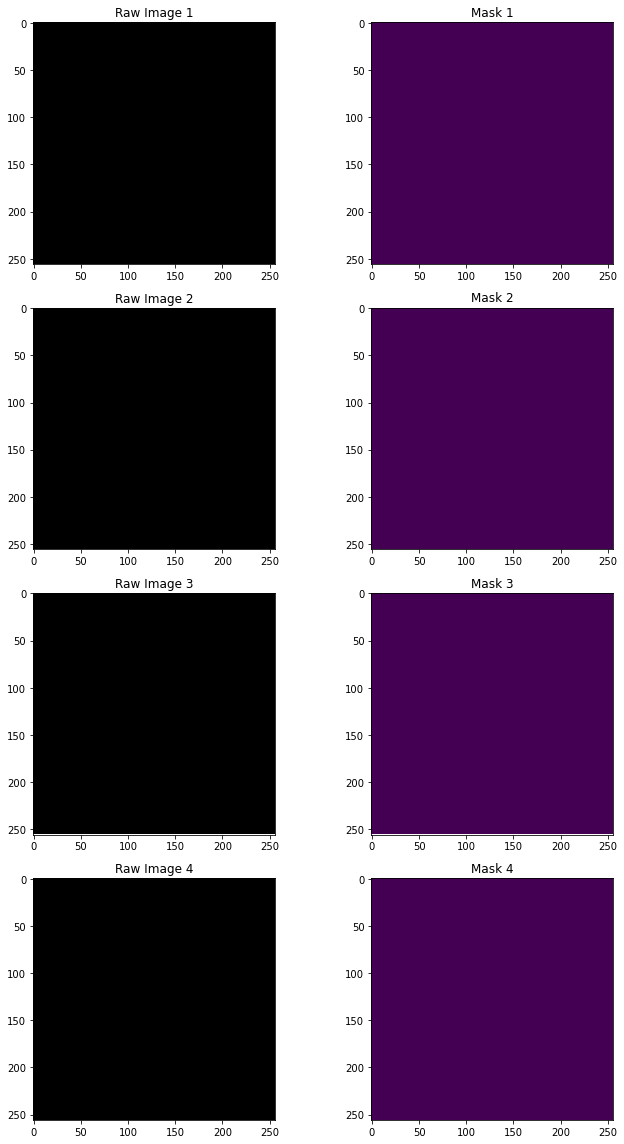

In [161]:
num_pairs = 4
plt.figure(figsize=(10, 4 * num_pairs))

for i in range(num_pairs):
    random_tile = np.random.randint(0, raw_patches.shape[0])

    # Raw Image
    plt.subplot(num_pairs, 2, 2 * i + 1)
    plt.title(f'Raw Image {i + 1}')
    plt.imshow(np.max(raw_patches[random_tile,0,0, :, :, :], axis=0), cmap='gray')

    # Multiclass Label
    plt.subplot(num_pairs, 2, 2 * i + 2)
    plt.title(f'Mask {i + 1}')
    plt.imshow(np.max(mask_patches[random_tile,0,0, :, :, :], axis=0))

plt.tight_layout()
plt.show()


In [89]:
raw_patches.shape

(123, 4, 4, 1, 256, 256)

In [162]:
input_img = np.reshape(raw_patches, (-1, raw_patches.shape[3], raw_patches.shape[4], raw_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))


input_img = np.squeeze(input_img, axis=1)
input_mask = np.squeeze(input_mask, axis=1)

print(input_img.shape)  # n_patches, x, y, z
print(input_mask.shape)

(1968, 256, 256)
(1968, 256, 256)


In [163]:
def remove_empty_images(data1, data2):
    if data1.shape != data2.shape:
        raise ValueError("Both datasets must have the same shape")

    non_empty_indices = [idx for idx, image in enumerate(data1) if np.max(image) > 0]
    filtered_data1 = data1[non_empty_indices]
    filtered_data2 = data2[non_empty_indices]

    return filtered_data1, filtered_data2

#remove pairs with no masks
input_mask, input_img = remove_empty_images(input_mask, input_img)

print(input_mask.shape, input_img.shape)

(396, 256, 256) (396, 256, 256)


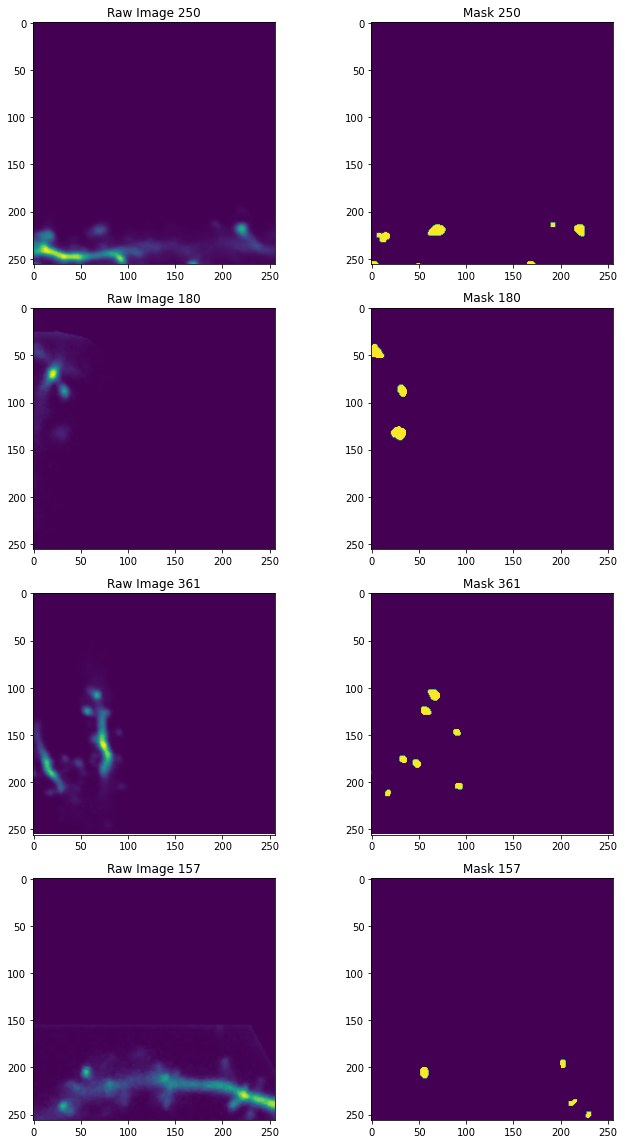

In [165]:
num_pairs = 4
plt.figure(figsize=(10, 4 * num_pairs))

for i in range(num_pairs):
    random_tile = np.random.randint(0, input_img.shape[0])

    # Raw Image
    plt.subplot(num_pairs, 2, 2 * i + 1)
    plt.title(f'Raw Image {random_tile}')
    plt.imshow(input_img[random_tile, :, :])

    # Multiclass Label
    plt.subplot(num_pairs, 2, 2 * i + 2)
    plt.title(f'Mask {random_tile}')
    plt.imshow(input_mask[random_tile, :, :])

plt.tight_layout()
plt.show()


In [166]:

def apply_random_augmentation(image):
    choice = random.choice(["none","blur", "brightness_contrast", "gamma", "hist_eq"])
    if choice =="none":
        return image
    
    if choice == "blur":
        sigma = random.uniform(0.5, 1)
        return gaussian_filter(image, sigma)
    elif choice == "brightness_contrast":
        brightness = random.uniform(0.8, 1)
        contrast = random.uniform(0.8, 1)
        return np.clip(contrast * (image - 32768) + 32768 + (brightness - 1) * 32768, 0, 65535)
    elif choice == "gamma":
        gamma = random.uniform(0.5, 1.1)
        return exposure.adjust_gamma(image, gamma)
    elif choice == "hist_eq":
        return exposure.equalize_hist(image)

def augment_2d_images(images, masks, rotations=(90, 180, 270), flip_axes=(0, 1), noise_std=0.01):
    augmented_images = []
    augmented_masks = []
    
    total_images = len(images)
    
    for idx, (image, mask) in enumerate(zip(images, masks)):

        progress = (idx + 1) / total_images * 100
        print(f"Processing image {idx + 1}/{total_images} ({progress:.2f}%)")

        # Original image and mask
        augmented_images.append(image)
        augmented_masks.append(mask)

        rotations_ranges = [(0, 90), (91, 180), (181, 270), (271, 360)]
        for rotation_range in rotations_ranges:
            angle = np.random.randint(rotation_range[0], rotation_range[1])  # Random angle
            rotated_image = rotate(image, angle, reshape=False)
            rotated_mask = rotate(mask, angle, reshape=False)

            # Apply a random augmentation to the rotated image
            augmented_rotated_image = apply_random_augmentation(rotated_image)

            augmented_images.append(augmented_rotated_image)
            augmented_masks.append(rotated_mask)

        # Flipping
        for axis in flip_axes:
            flipped_image = np.flip(image, axis=axis)
            flipped_mask = np.flip(mask, axis=axis)
            augmented_images.append(flipped_image)
            augmented_masks.append(flipped_mask)

        # Add Gaussian noise
        #noisy_image = image + np.random.normal(0, noise_std, image.shape)
        #augmented_images.append(noisy_image)
        #augmented_masks.append(mask)

    return np.array(augmented_images), np.array(augmented_masks)

input_img, input_mask = augment_2d_images(input_img, input_mask)
input_img.shape

Processing image 1/396 (0.25%)
Processing image 2/396 (0.51%)
Processing image 3/396 (0.76%)
Processing image 4/396 (1.01%)
Processing image 5/396 (1.26%)
Processing image 6/396 (1.52%)
Processing image 7/396 (1.77%)
Processing image 8/396 (2.02%)
Processing image 9/396 (2.27%)
Processing image 10/396 (2.53%)
Processing image 11/396 (2.78%)
Processing image 12/396 (3.03%)
Processing image 13/396 (3.28%)
Processing image 14/396 (3.54%)
Processing image 15/396 (3.79%)
Processing image 16/396 (4.04%)
Processing image 17/396 (4.29%)
Processing image 18/396 (4.55%)
Processing image 19/396 (4.80%)
Processing image 20/396 (5.05%)
Processing image 21/396 (5.30%)
Processing image 22/396 (5.56%)
Processing image 23/396 (5.81%)
Processing image 24/396 (6.06%)
Processing image 25/396 (6.31%)
Processing image 26/396 (6.57%)
Processing image 27/396 (6.82%)
Processing image 28/396 (7.07%)
Processing image 29/396 (7.32%)
Processing image 30/396 (7.58%)
Processing image 31/396 (7.83%)
Processing image 

Processing image 249/396 (62.88%)
Processing image 250/396 (63.13%)
Processing image 251/396 (63.38%)
Processing image 252/396 (63.64%)
Processing image 253/396 (63.89%)
Processing image 254/396 (64.14%)
Processing image 255/396 (64.39%)
Processing image 256/396 (64.65%)
Processing image 257/396 (64.90%)
Processing image 258/396 (65.15%)
Processing image 259/396 (65.40%)
Processing image 260/396 (65.66%)
Processing image 261/396 (65.91%)
Processing image 262/396 (66.16%)
Processing image 263/396 (66.41%)
Processing image 264/396 (66.67%)
Processing image 265/396 (66.92%)
Processing image 266/396 (67.17%)
Processing image 267/396 (67.42%)
Processing image 268/396 (67.68%)
Processing image 269/396 (67.93%)
Processing image 270/396 (68.18%)
Processing image 271/396 (68.43%)
Processing image 272/396 (68.69%)
Processing image 273/396 (68.94%)
Processing image 274/396 (69.19%)
Processing image 275/396 (69.44%)
Processing image 276/396 (69.70%)
Processing image 277/396 (69.95%)
Processing ima

(2772, 256, 256)

In [167]:
# in case processing introduces pairs without masks - filter these out

input_mask, input_img = remove_empty_images(input_mask, input_img)

print(input_mask.shape, input_img.shape)

(2602, 256, 256) (2602, 256, 256)


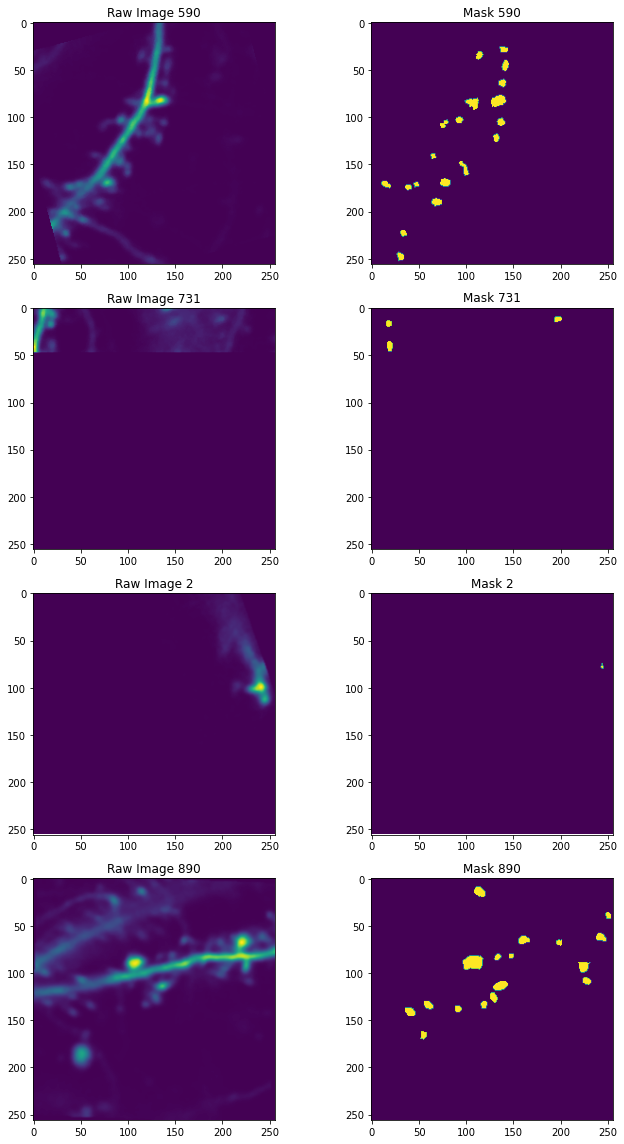

In [169]:
#plot some example pairs
num_pairs = 4
plt.figure(figsize=(10, 4 * num_pairs))

for i in range(num_pairs):
    random_tile = np.random.randint(0, input_img.shape[0])

    # Raw Image
    plt.subplot(num_pairs, 2, 2 * i + 1)
    plt.title(f'Raw Image {random_tile}')
    plt.imshow(input_img[random_tile, :, :])

    # Multiclass Label
    plt.subplot(num_pairs, 2, 2 * i + 2)
    plt.title(f'Mask {random_tile}')
    plt.imshow(input_mask[random_tile, :, :])

plt.tight_layout()
plt.show()

In [170]:
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=3)
train_mask = train_mask.astype(np.float32)
print(train_img.shape)
print(train_mask.shape)

(2602, 256, 256, 3)
(2602, 256, 256, 1)


In [106]:
#Define the model
n_classes=1 #Number of classes for segmentation

BACKBONE = 'resnet34'
activation = 'sigmoid'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_img_r=preprocess_input(train_img)
print(train_img_r.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_img_r, train_mask, test_size = 0.15, random_state = 42)
print(X_train.shape)
print(X_test.shape)


# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation = activation)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
#print(model.summary())

model_name="C:/Users/Luke_H/Desktop/SpineV3/2023_05_spine_2D 256x256_resnet34_V3_2.h5"

(2588, 256, 256, 3)
(2199, 256, 256, 3)
(389, 256, 256, 3)


In [107]:
#set up tensorboard
import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
#setup tensorboard callback
log_dir = ("D:/tensorflow_logs/"+ time.strftime("%Y%m%d-%H%M%S"))
print("Logs will be saved to: "+log_dir)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#setup modelcheckpoint callback:
# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_name,       # Path where to save the model
    monitor='val_iou_score',         # Monitor the validation IoU metric
    mode='max',                # Save the model with the highest validation IoU
    save_best_only=True,       # Only save the best model
    verbose=1                  # Print a message when a new best model is found
)




Logs will be saved to: D:/tensorflow_logs/20230601-164126


In [141]:
history=model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=300,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, model_checkpoint_callback])


#46816


In [142]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [171]:
# load a model for inference/prediction

from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model(model_name, compile=False)

import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
threshold = 0.05

# size of patches
patch_size = 256


#Break the large image (volume) into patches of same size as the training images (patches)
image = io.imread("C:/Users/Luke_H/Desktop/SpineV3/Unseen/SRGAP2A-03-3196-Day1-apical9_sorted_processed.tif")
image = image.astype(np.float32)
patches = patchify(image, (1, 256, 256), step=(1, 256,256))  #Step=256 for 256 patches means no overlap
print("Input shape is ",image.shape)
print("Input patch shape is ", patches.shape)


Input shape is  (10, 256, 1024)
Input patch shape is  (10, 1, 4, 1, 256, 256)


In [172]:
# Consider adding overlap and vote for mask - if ncessary

# Predict each patch   
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
         for k in range(patches.shape[2]):
            #print(i,j,k)
            single_patch = patches[i,j,k,:,:,:]
            single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
            single_patch_3ch = np.squeeze(single_patch_3ch)
            #print(single_patch_3ch.shape)
            single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
            single_patch_prediction = model.predict(single_patch_3ch_input, verbose=0)
            mask = np.squeeze(single_patch_prediction)
            mask = np.where(mask > threshold, 255, 0)
            predicted_patches.append(mask)



In [173]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print("Predicted patches shape is ",predicted_patches.shape)
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1],patches.shape[2],patches.shape[3],
                                         256, 256) )
print("Predicted patches reshaped is ",predicted_patches_reshaped.shape)
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, image.shape)
print("Reconstructed shape is ",reconstructed_image.shape)
print("Reconstructed type is ",reconstructed_image.dtype)

#unpad
#reconstructed_image = unpad_image(reconstructed_image, original_shape, padding)
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)

print("Reconstructed type convereted to ",reconstructed_image.dtype)

#Now save it as segmented volume.
from tifffile import imsave
imsave("C:/Users/Luke_H/Desktop/SpineV3/SRGAP2A-03-3196-Day1-apical9_sorted_processed-mask.tif", reconstructed_image)

Predicted patches shape is  (40, 256, 256)
Predicted patches reshaped is  (10, 1, 4, 1, 256, 256)
Reconstructed shape is  (10, 256, 1024)
Reconstructed type is  int32
Reconstructed type convereted to  uint8


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\519397338.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/SRGAP2A-03-3196-Day1-apical9_sorted_processed-mask.tif", reconstructed_image)


In [ ]:
#add in scikit image label

In [174]:
# Detects immune cells for multiclass unet output
def spine_detection(inputimage, erosion, holes):
  #spine_cores = ndimage.binary_erosion(inputimage, structure=np.ones(erosion)).astype(immune_cores.dtype)
    labels = label(inputimage)

    #labels = morphology.remove_small_holes(labels, holes)

    #labels = segmentation.watershed(inputimage, labels, mask=inputimage)

    #Remove objects touching border
    labels_padded = np.pad(
        labels,
        ((1, 1), (0, 0), (0, 0)),
        mode='constant',
        constant_values=0,
    )
    labels = segmentation.clear_border(labels_padded)[1:-1]

    return labels

#modified for single channel - can be modified to measure int in multiple channels

def spine_measurements(labels, image, sizes, output_dir, filename):
    """    
    Returns:
        pandas table and filtered labels
    """
    region_props = measure.regionprops(labels)

    main_table = pd.DataFrame(
        measure.regionprops_table(
            labels,
            intensity_image=image[:,:,:], #select intensity channel here if multichannel
            properties=['label', 'centroid', 'area', 'mean_intensity', 'max_intensity'], #area is volume for 3D images
            )
        )

    #rename mean intensity
    main_table.rename(columns={'mean_intensity':'C1_mean_int'}, inplace=True)
    main_table.rename(columns={'max_intensity':'C1_max_int'}, inplace=True)
    main_table.rename(columns={'centroid-0':'z'}, inplace=True)
    main_table.rename(columns={'centroid-1':'y'}, inplace=True)
    main_table.rename(columns={'centroid-2':'x'}, inplace=True)
    main_table.rename(columns={'area':'volume'}, inplace=True)
        
    #filter out small objects
    volume_min = sizes[0] #5
    volume_max = sizes[1] #1000?    
    print(" Filtering spines between size ",volume_min," and ",volume_max," voxels...")
    filtered_table = main_table[(main_table['volume'] > volume_min) & (main_table['volume'] < volume_max) ] 
    labels = create_filtered_labels_image(labels, filtered_table)

    print(" After filtering", len(filtered_table), "spines remain from total of", len(main_table))
    #save table
    filename = filename.replace('.tif', '')
    filtered_table.to_csv(output_dir + 'Detected_spines_'+filename+'.csv',index=False) 
    
    return filtered_table, labels

def create_filtered_labels_image(labels, filtered_table):
    """
    Create a new labels image using a filtered regionprops table, more efficiently.

    Args:
        labels (numpy.ndarray): Input labels image.
        filtered_table (pd.DataFrame): Filtered regionprops table.

    Returns:
        numpy.ndarray: Filtered labels image.
    """
    # Create a mask that retains only the labels present in the filtered_table
    mask = np.isin(labels, filtered_table['label'].values)

    # Create the filtered labels image by multiplying the mask with the original labels
    filtered_labels = labels * mask

    return filtered_labels


 Filtering spines between size  5  and  1000  voxels...
 After filtering 92 spines remain from total of 101


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\3724197049.py:16: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/SRGAP2A-03-3196-Day1-apical9_sorted_processed-labels.tif", filtered_labels)


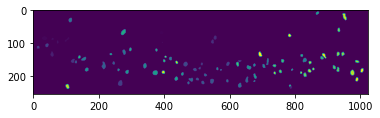

In [175]:
output_dir = "C:/Users/Luke_H/Desktop/SpineV3/"
output_name = "SRGAP2A-03-3196-Day1-apical9_sorted_processed-labels.tif"
sizes = (5,1000)

labels = spine_detection(reconstructed_image, #input - expects unet output
            (1,1,1), #erosion used for making cores if cells aren't sufficiently seperated by inner label
            10 ** 3, #value used to remove small holes in outer immune label - can be removed with tiles blending smoothly
            )
plt.imshow(np.max(labels, axis=0))

table, filtered_labels = spine_measurements(labels, image, sizes, output_dir, output_name)

plt.imshow(np.max(filtered_labels, axis=0))

filtered_labels=filtered_labels.astype(np.uint8) #OK if less than 255 spines, else 16-bit
imsave("C:/Users/Luke_H/Desktop/SpineV3/SRGAP2A-03-3196-Day1-apical9_sorted_processed-labels.tif", filtered_labels)

In [143]:
data_dirs = ["C:/Users/Luke_H/Desktop/SpineV3/Unseen/"]

output_dir = "C:/Users/Luke_H/Desktop/SpineV3/"
output_name = "SDCunseen-labels.tif"
sizes = (5,1000)


for data_dir in data_dirs:
    print("Processing folder: "+data_dir)
    files = [file_i
             for file_i in os.listdir(data_dir)
             if file_i.endswith('.tif')]
    
    for file in range(len(files)):
        print('Processing file '+files[file])
        
        labels = spine_detection(reconstructed_image, #input - expects unet output
            (1,1,1), #erosion used for making cores if cells aren't sufficiently seperated by inner label
            10 ** 3, #value used to remove small holes in outer immune label - can be removed with tiles blending smoothly
            )
        table, filtered_labels = spine_measurements(labels, image, sizes, output_dir, files[file])
        
        filtered_labels=filtered_labels.astype(np.uint8) #OK if less than 255 spines, else 16-bit
        imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)

Processing folder: C:/Users/Luke_H/Desktop/SpineV3/Unseen/
Processing file 33_2AFF_036_Segment1_Day7_processed.tif
 Filtering spines between size  5  and  1000  voxels...
 After filtering 34 spines remain from total of 42
Processing file 61-B6-028-Day1-apical8_sorted-1_processed.tif


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\1281458244.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)
C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\1281458244.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)


 Filtering spines between size  5  and  1000  voxels...
 After filtering 34 spines remain from total of 42
Processing file 61-B6-028-Day7-apical6_sorted-1_processed.tif
 Filtering spines between size  5  and  1000  voxels...
 After filtering 34 spines remain from total of 42
Processing file 61-B6-030-Day2-apical8_sorted-1_processed.tif
 Filtering spines between size  5  and  1000  voxels...
 After filtering 34 spines remain from total of 42
Processing file SRGAP2A-03-3196-Day1-apical9_sorted_processed.tif
 Filtering spines between size  5  and  1000  voxels...


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\1281458244.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)
C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\1281458244.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)


 After filtering 34 spines remain from total of 42


C:\Users\Luke_H\AppData\Local\Temp\ipykernel_3316\1281458244.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("C:/Users/Luke_H/Desktop/SpineV3/"+files[file], filtered_labels)
